In [2]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
print(type(x_train))
print(f"\033[95m↓ x_train.shape ↓\033[0m\n{x_train.shape}")
print(f"\033[95m↓ y_train.shape ↓\033[0m\n{y_train.shape}")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

<class 'numpy.ndarray'>
↓ x_train.shape ↓
(3601, 500)
↓ y_train.shape ↓
(3601,)


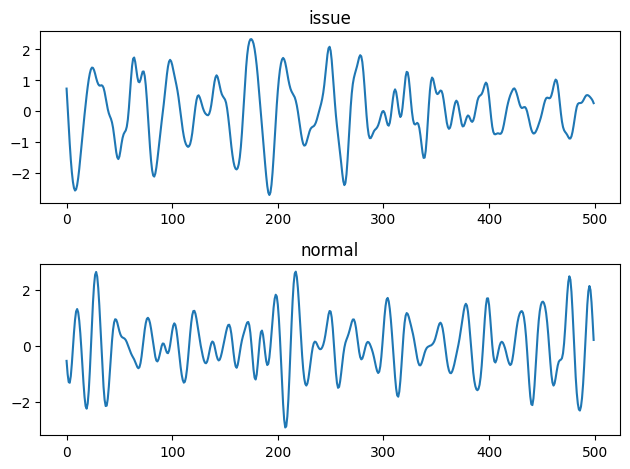

In [3]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

fig, axes = plt.subplots(2, 1)

for index, c in enumerate(classes):
    c_x_train = x_train[y_train == c]

    if c == 1:
        label = "normal"
    else:
        label = "issue"
    
    axes.flat[index].plot(c_x_train[1])
    axes.flat[index].set_title(label)

plt.tight_layout()
plt.show()
plt.close()

In [4]:
x_train = x_train[:,:,np.newaxis]
x_test = x_test[:,:,np.newaxis]

In [5]:
num_classes = len(np.unique(y_train))
print(f"\033[95m↓ num_classes ↓\033[0m\n{num_classes}")

↓ num_classes ↓
2


In [6]:
idx = np.random.permutation(len(x_train))
print(f"\033[95m↓ idx ↓\033[0m\n{idx}")

↓ idx ↓
[3262  719 1528 ... 2464 1459 3386]


In [7]:
# Convert class -1(issue) to zero
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

In [8]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

model = make_model(input_shape=x_train.shape[1:])
# keras.utils.plot_model(model, show_shapes=True)


In [9]:
epochs = 100
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

skip = True 
if not skip:
    history = model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        validation_split=0.2,
        verbose=1,
    )

In [10]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

42/42 [==============================] - 0s 5ms/step - loss: 0.1176 - sparse_categorical_accuracy: 0.9636
Test accuracy 0.9636363387107849
Test loss 0.11759456247091293


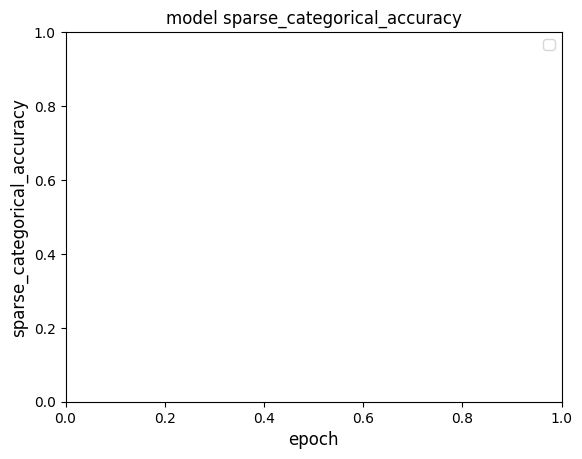

In [12]:
metric = "sparse_categorical_accuracy"
plt.figure()
if not skip:
    plt.plot(history.history[metric])
    plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [14]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res